In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from datetime import datetime
from dateutil.parser import parse
from sklearn.model_selection import train_test_split
from IPython.display import display as dsp

# United States Drug Prices: Forecasting and Analysis

## Data Collection

In [2]:
#Socrata SQL query
SODA = '$limit=500000'
URL = 'https://data.medicaid.gov/resource/444w-ftrz.csv?{}'.format(SODA)

TRAIN_SPLIT = 0.8

In [3]:
def list_unique_counts(df):
    for col in df.columns:
        print(col, '\n', len(df[str(col)].unique()))
    print('Total Number Observations:\n', df.shape[0])

def train_split(df, TRAIN_SPLIT):
    split_point = int(len(df) * (TRAIN_SPLIT))
    train = df[:split_point]
    test = df[split_point:]
    return train, test

def strip_time(date):
    date = date.replace('T00:00:00.000', '')
    return datetime.strptime(date, '%Y-%m-%d')

def return_name(ndc_description):
    if len(ndc_description) == 0:
        return '','','',''
    drug_name, dosage, dosage_unit, drug_form = [], np.nan, np.nan, np.nan
    
    #Check and see if we are dealing with concentration
    concentration = False
    if set('%') <= set(ndc_description):
        concentration = True
        ndc_description.replace('%', '')
    
    #Create our array of words
    words = ndc_description.split()
    
    for i in range(len(words)):
        if not words[i].replace('.','').replace('%', '').isnumeric():
            drug_name.append(words[i])
            
        if words[i].replace('.','').replace('%','').isnumeric():
            dosage = float(words[i].replace('%', ''))
            
            if not concentration:
                try:
                    dosage_unit = words[i + 1]
                    drug_form = ' '.join(words[i + 2:])
                except:
                    drug_form = ' '.join(words[i:])
                    #print(ndc_description, concentration)
                break
            
            if concentration:
                dosage_unit = 'concentration'
                drug_form = ' '.join(words[i + 1:])
                break
            
    drug_name = ' '.join(drug_name)
    return pd.Series([drug_name, dosage, dosage_unit, drug_form])

def drop_na_printout(dataframe):
    i = dataframe.shape[0]
    j = dataframe.dropna().shape[0]
    
    percent_loss = (i - j) / i * 100
    
    print(percent_loss, '% data lost in cleaning.')
    
    return dataframe.dropna()

def one_hot_encoder(series):
    results = pd.DataFrame()
    for entry in series.unique():
        results[str(series.name) + '_' + str(entry)] = series.apply(lambda x: np.where(x == entry, 1, 0))
        
    return results

In [4]:
raw = pd.read_csv(URL, parse_dates = True)

#Convert dates to date format
raw['start_date'] = raw['start_date'].apply(lambda x: strip_time(x))
raw['end_date'] = raw['end_date'].apply(lambda x: strip_time(x))

#Remove Effective Date
raw = raw.drop('effective_date', 1)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print(raw.columns)

#Create 'days_effective' and 'day_count' columns
raw['days_effective'] = (raw['end_date'] - raw['start_date'])
raw['days_effective'] = raw['days_effective'].apply(lambda x: x.days)

raw['days_count'] = (raw['start_date'] - min(raw['start_date']))
raw['days_count'] = raw['days_count'].apply(lambda x: x.days)

#Create 'month-year' column because most changes happen in the middle of every month
raw['year-month'] = raw['start_date'].apply(lambda x: x.strftime('%Y-%m'))

#Add drug name column, we want to ignore dosage and format
raw[['drug_name', 'dosage','dosage_unit','drug_form']] = \
raw['ndc_description'].apply(lambda x: return_name(x))
    
#Remove all first-date entries
if len(raw['start_date'].unique()) > 1:
    raw.drop(raw[raw['start_date'] == min(raw['start_date'])].index, inplace = True)

#Remove last month of data, this is typically truncated by the limitations of our API call
if len(raw['year-month']) > 3:
    raw.drop(raw[raw['year-month'] == max(raw['year-month'])].index, inplace = True)

dsp(raw.head())

Index(['ndc_description', 'ndc', 'old_nadac_per_unit', 'new_nadac_per_unit',
       'classification_for_rate_setting', 'percent_change', 'primary_reason',
       'start_date', 'end_date'],
      dtype='object')


,ndc_description,ndc,old_nadac_per_unit,new_nadac_per_unit,classification_for_rate_setting,percent_change,primary_reason,start_date,end_date,days_effective,days_count,year-month,drug_name,dosage,dosage_unit,drug_form
24,ALREX 0.2% EYE DROPS,24208035305,27.08802,29.52622,B,9.00,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ALREX,0.2,concentration,EYE DROPS
25,ALREX 0.2% EYE DROPS,24208035310,27.39300,29.85892,B,9.00,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ALREX,0.2,concentration,EYE DROPS
26,ATIVAN 0.5 MG TABLET,64455006301,4.35697,5.06236,B,16.19,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ATIVAN,0.5,MG,TABLET
27,ATIVAN 1 MG TABLET,64455006401,5.84274,6.78862,B,16.19,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ATIVAN,1.0,MG,TABLET
28,ATIVAN 1 MG TABLET,64455006410,5.84274,6.78862,B,16.19,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ATIVAN,1.0,MG,TABLET


In [ ]:
#old_nadac_per_unit, new_nadac_per_unit, classification_for_rate_setting, percent_change, primary_reason, year-month
#drug_name, dosage, dosage_unit, drug_form

In [6]:
raw = drop_na_printout(raw)

13.085503719321077 % data lost in cleaning.


In [ ]:
raw['scaled_old_per_unit'] = max(raw[raw['']])

In [46]:
#These will become our scaled-by-dosage columns
raw['scaled_old_per_unit'] = raw['old_nadac_per_unit']
raw['scaled_new_per_unit'] = raw['new_nadac_per_unit']

for drug in raw['drug_name'].unique():
    
    #Create Dataframe Specific to drug
    drug_info = raw[raw['drug_name'] == drug]
    
    #Check and see if there are more than one dosage
    if len(drug_info['dosage'].unique()) > 1:
        
        #Look at every unique date available to the individual drug
        for date in drug_info['start_date'].unique():
            
            #Create dataframe for the drug within each unique date
            drug_date_info = drug_info[drug_info['start_date'] == date]
            
            #See if there are more than one dosages represented in the date
            if len(drug_date_info['dosage']) > 1:
                
                #Perform scaling opperations
                largest_dosage = max(drug_date_info['dosage'])
                
                #Set the value in the newly created column: Note if there aren't enough dosages to scale, the scaled
                #price is not altered from its original value.
                raw[(raw['start_date'] == date) & (raw['drug_name']) == drug]['scaled_old_per_unit'] = \
                largest_dosage / drug_date_info['dosage'] * drug_date_info['old_nadac_per_unit']
                
                raw[(raw['start_date'] == date) & (raw['drug_name']) == drug]['scaled_new_per_unit'] = \
                largest_dosage / drug_date_info['dosage'] * drug_date_info['new_nadac_per_unit']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyboardInterrupt: 

In [7]:
print('This dataset represents {} unique NDCs over {} entries.'.format(len(raw['ndc'].unique()), raw.shape[0]))
print('There are {} unique NDC descriptions represented in this dataset.'.format(len(raw['ndc_description'].unique())))

print('\nUnique Values in Raw Data per Column:')
list_unique_counts(raw)

print(raw['start_date'].dtype)

print(raw['days_effective'].unique())

This dataset represents 41876 unique NDCs over 416775 entries.
There are 4787 unique NDC descriptions represented in this dataset.

Unique Values in Raw Data per Column:
ndc_description 
 4787
ndc 
 41876
old_nadac_per_unit 
 49345
new_nadac_per_unit 
 49387
classification_for_rate_setting 
 2
percent_change 
 6081
primary_reason 
 4
start_date 
 107
end_date 
 107
days_effective 
 2
days_count 
 107
year-month 
 25
drug_name 
 2350
dosage 
 215
dosage_unit 
 134
drug_form 
 368
Total Number Observations:
 416775
datetime64[ns]
[6 7]


In [8]:
print('Top value counts for NDC:')
dsp(raw['ndc'].value_counts().sort_values(ascending = False).head())

print('\nTop value counts for NDC description:')
dsp(raw['ndc_description'].value_counts().sort_values(ascending = False).head())

Top value counts for NDC:


31722040501    22
59762502301    22
60505255101    22
60505255105    22
51079076530    22
Name: ndc, dtype: int64


Top value counts for NDC description:


METFORMIN HCL 500 MG TABLET      1976
LISINOPRIL 20 MG TABLET          1628
LISINOPRIL 10 MG TABLET          1567
AMLODIPINE BESYLATE 5 MG TAB     1551
AMLODIPINE BESYLATE 10 MG TAB    1508
Name: ndc_description, dtype: int64

### Normalization

In [36]:
#Check correlation between dosage and price witin each drug
top_10 = raw['drug_name'].value_counts().sort_values(ascending = False)[:20].index

In [37]:
#Check correlation between dosage and price within individual drugs
print('Dosage to per-unit price correlation for 10 most changed drugs:\n')
print('(Pearson Correlation Coefficient, P-Value)')
for drug in top_10:
    drug_changelog = raw[raw['drug_name'] == drug]
    print(drug)
    print(stats.pearsonr(drug_changelog['new_nadac_per_unit'].values, drug_changelog['dosage'].values))

Dosage to per-unit price correlation for 10 most changed drugs:

(Pearson Correlation Coefficient, P-Value)
LISINOPRIL
(0.864420129149428, 0.0)
RISPERIDONE
(0.2033609498629652, 5.499571296895248e-52)
GABAPENTIN
(0.8569656229109558, 0.0)
SIMVASTATIN
(0.8618310041791036, 0.0)
AMLODIPINE BESYLATE
(0.7568323175886235, 0.0)
QUETIAPINE FUMARATE
(0.9519636727113635, 0.0)
IBUPROFEN
(0.7836383973226292, 0.0)
METFORMIN HCL
(0.9742844110646679, 0.0)
OLANZAPINE
(0.9801290331139227, 0.0)
CITALOPRAM HBR
(-0.08183624262301034, 4.367269436408418e-06)
LEVETIRACETAM
(0.911590313135831, 0.0)
AMOXICILLIN
(0.5428050462190125, 2.6259675320258957e-234)
CARVEDILOL
(0.42290241643306814, 1.0370271316225878e-131)
LOSARTAN POTASSIUM
(0.8802892558883041, 0.0)
LAMOTRIGINE
(-0.2922914888777595, 1.0232722712910593e-57)
MONTELUKAST SOD
(-0.2681767547853191, 4.2858183401626166e-45)
SERTRALINE HCL
(0.317493212045036, 4.3023427563742916e-62)
PIOGLITAZONE HCL
(0.8569806152381154, 0.0)
ALPRAZOLAM
(0.07107803147447654, 0.00

In [11]:
#Create drugs dataframe
drugs = raw[['drug_name','old_nadac_per_unit','new_nadac_per_unit']].groupby(['drug_name']).mean().rename(
    {'old_nadac_per_unit' : 'old_average_per_unit','new_nadac_per_unit': 'new_average_per_unit'}, axis = 1)
drugs['percent_average_change'] = (drugs['new_average_per_unit'] 
                                   - drugs['old_average_per_unit']) / drugs['new_average_per_unit'] * 100

In [12]:
max_price, min_price, max_dosage = [], [], []
for drug in drugs.index:
    max_price.append(max(raw[raw['drug_name'] == drug]['new_nadac_per_unit']))
    min_price.append(min(raw[raw['drug_name'] == drug]['new_nadac_per_unit']))
    max_dosage.append(max(raw[raw['drug_name'] == drug]['dosage']))
drugs['max_per_unit'] = max_price
drugs['min_per_unit'] = min_price
drugs['max_dosage'] = max_dosage
drugs.head()

,old_average_per_unit,new_average_per_unit,percent_average_change,max_per_unit,min_per_unit,max_dosage
drug_name,,,,,,
,0.061608,0.061494,-0.185384,0.06650,0.05932,8.0
12-HR DECONGEST,0.341570,0.342896,0.386823,0.37681,0.32264,120.0
ABACAVIR,4.303600,4.246232,-1.351048,6.13318,3.09071,300.0
ABILIFY,28.790676,30.332430,5.082858,40.98323,5.50154,30.0
ABILIFY DISCMELT,30.165025,34.659615,12.967801,35.01615,34.30308,15.0


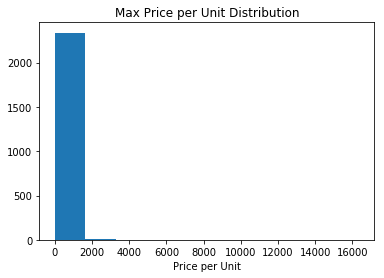

In [13]:
plt.title('Max Price per Unit Distribution')
#drugs[(np.abs(stats.zscore(drugs)) < 1).all(axis=1)]
plt.hist(drugs['max_per_unit'])

plt.xlabel('Price per Unit')
plt.show()

In [14]:
#Scale Prices by Dosage

### Metrics for General Volatility

#### Changes per Day

In [15]:
#Changes per day
change_count = raw['start_date'].value_counts().sort_index()
dsp(change_count.head())

print('Our data represents the range of dates between {} and {}'.format(change_count.index.min().strftime('%Y-%m-%d'),
                                                                        change_count.index.max().strftime('%Y-%m-%d')))

2013-12-05      105
2013-12-11    15729
2013-12-18       61
2013-12-25       11
2014-01-08      318
Name: start_date, dtype: int64

Our data represents the range of dates between 2013-12-05 and 2015-12-30


In [16]:
print(change_count.sort_values(ascending = False)[:10])

2015-12-16    17269
2015-11-11    17249
2015-07-15    16932
2015-10-14    16918
2015-06-10    16859
2015-02-11    16763
2015-08-12    16731
2015-05-13    16719
2014-11-12    16693
2015-04-15    16626
Name: start_date, dtype: int64


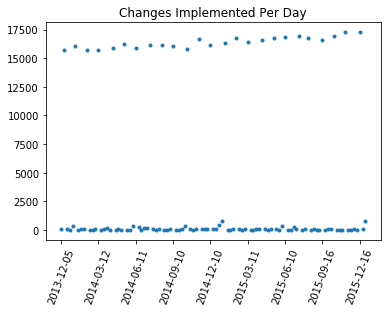

In [17]:
plt.title('Changes Implemented Per Day')
plt.plot(change_count.index.strftime('%Y-%m-%d'), change_count.values, '.')
plt.xticks(np.arange(0,len(change_count.index), round((len(change_count.index)) / 8)), rotation = 70)
plt.show()

##### What kind of changes happen at what times.

In [ ]:
#Group dates into high-change days or low change days
CHANGE_LIMIT = 10000

#Group by day
daily = raw.groupby()

#### Changes per Month

In [18]:
mnth_count = raw['year-month'].value_counts().sort_index()
mnth_count.head()

2013-12    15906
2014-01    16419
2014-02    15824
2014-03    15864
2014-04    16187
Name: year-month, dtype: int64

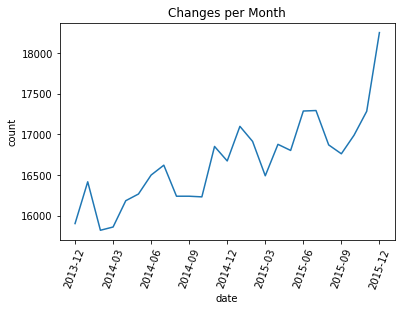

In [19]:
plt.title('Changes per Month')
plt.plot(mnth_count)
plt.xticks(np.arange(0,len(mnth_count.index), round((len(mnth_count.index)) / 8)), rotation = 70)
plt.xlabel('date')
plt.ylabel('count')
plt.show()

#### Average Rate Change per Month

In [20]:
mnth_avgs = raw.groupby(['year-month']).mean()
mnth_avgs.head()

,old_nadac_per_unit,new_nadac_per_unit,percent_change,days_effective,days_count,dosage
year-month,,,,,,
2013-12,1.833895,1.896660,5.073839,6.993399,12.996919,108.309114
2014-01,3.760482,3.888046,7.562463,7.000000,47.923686,106.965057
2014-02,4.357223,4.487732,-2.906283,7.000000,76.014156,107.657281
2014-03,2.195605,2.222135,0.376311,7.000000,103.998676,107.128001
2014-04,1.888697,1.899964,0.199421,7.000000,138.861617,107.159301


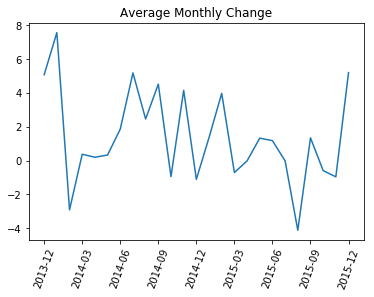

In [21]:
plt.title('Average Monthly Change')
plt.plot(mnth_avgs['percent_change'])
plt.xticks(np.arange(0,len(mnth_avgs.index), round((len(mnth_avgs.index)) / 8)), rotation = 70)
plt.show()

Text(0, 0.5, 'Observations')

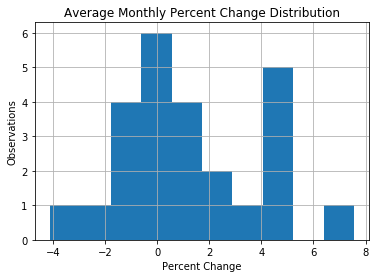

In [22]:
plt.title('Average Monthly Percent Change Distribution')
mnth_avgs['percent_change'].hist()
plt.xlabel('Percent Change')
plt.ylabel('Observations')

#### Total Price Gain/Loss per Month

In [23]:
raw['total_price_change'] = raw['new_nadac_per_unit'] - raw['old_nadac_per_unit']
mnth_sum = raw.groupby(['year-month']).sum()

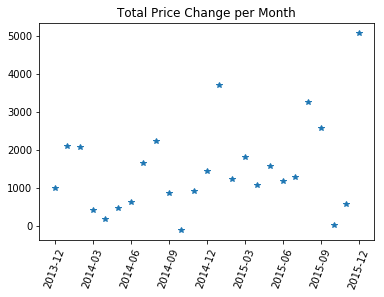

In [24]:
plt.title('Total Price Change per Month')
plt.plot(mnth_sum['total_price_change'], '*')
plt.xticks(np.arange(0,len(mnth_sum.index), round((len(mnth_sum.index)) / 8)), rotation = 70)
plt.show()

### Forecasting

#### Generic and Branded

96.8% of changes are to generic medicines.


/home/alexander/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


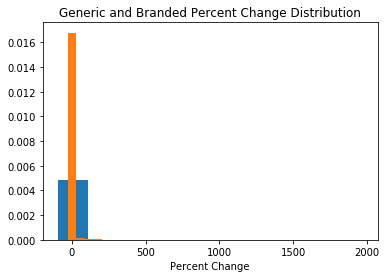

Mean Percent Change for Generic Drugs: 1.23%
Mean Percent Change for Branded Drugs: 6.29%
Standad Deviation for Generic Drugs: 27.12%
Standad Deviation for Branded Drugs: 17.64%
T-Statistic: -21.0
P-Value: 0.0


In [25]:
print('{}% of changes are to generic medicines.'.format(round(len(raw[raw['classification_for_rate_setting'] == 'G'])
                                                              / raw.shape[0], 3) * 100))

raw_generic = raw[raw['classification_for_rate_setting'] == 'G']['percent_change']
raw_branded = raw[raw['classification_for_rate_setting'] == 'B']['percent_change']

#Compare how often and the magnitude of change between generic and branded medicine.
plt.title('Generic and Branded Percent Change Distribution')
plt.hist(raw_generic, normed = True)
plt.hist(raw_branded, normed = True)

plt.xlabel('Percent Change')
plt.show()

#Print Stats
print('Mean Percent Change for Generic Drugs: {}%'.format(round(raw_generic.mean() ,2)))
print('Mean Percent Change for Branded Drugs: {}%'.format(round(raw_branded.mean() ,2)))

print('Standad Deviation for Generic Drugs: {}%'.format(round(raw_generic.std() ,2)))
print('Standad Deviation for Branded Drugs: {}%'.format(round(raw_branded.std() ,2)))

#T-test
t_stat, p_val = stats.ttest_ind(raw_generic, raw_branded)

print('T-Statistic: {}'.format(round(t_stat)))
print('P-Value: {}'.format(round(p_val)))


In [26]:
print(raw.head())

         ndc_description          ndc  old_nadac_per_unit  new_nadac_per_unit  \
24  ALREX 0.2% EYE DROPS  24208035305            27.08802            29.52622   
25  ALREX 0.2% EYE DROPS  24208035310            27.39300            29.85892   
26  ATIVAN 0.5 MG TABLET  64455006301             4.35697             5.06236   
27    ATIVAN 1 MG TABLET  64455006401             5.84274             6.78862   
28    ATIVAN 1 MG TABLET  64455006410             5.84274             6.78862   

   classification_for_rate_setting  percent_change  primary_reason start_date  \
24                               B            9.00  WAC Adjustment 2013-12-05   
25                               B            9.00  WAC Adjustment 2013-12-05   
26                               B           16.19  WAC Adjustment 2013-12-05   
27                               B           16.19  WAC Adjustment 2013-12-05   
28                               B           16.19  WAC Adjustment 2013-12-05   

     end_date  days_effect

In [27]:
#classification:  how volatile the durg price changes are
#features, how often the price is changes (new column); classification, percent_change, primary reason

In [28]:

#remove duplicattes; ndc_desc, olds_nadac, new_nadac, class, percetn_change, primary reason, start_date

In [29]:
#get dosage (1mg ); calculate the price per unit; average if necessary
# Ativan 0.5 MG -> 1.0MG; 4.35697 * 2
# Ativan 1.0 MG 
# Ativan 1.0 MG  5. 9will be a duplicate )
old_nadac = (4.35697 x 2 + 5.84274 ) / 2

SyntaxError: invalid syntax (<ipython-input-29-0c67b513e40f>, line 5)

In [ ]:
#finacl column
durg_name, start_date, old_nac, new_nadac, classi, percent change(calc again), total_rice_ch (calc again)

#### Individual Drugs

__By NDC Description__

In [ ]:
#Find most frequently changed ndc prices
top_25_desc = raw['drug_name'].value_counts().sort_values(ascending = False)[:25]

#Find Database to group these drugs by their use.
#Create regex to find drug names (ie metformin HCL is all the same) Stop at the number. call it ndc_name of ndc_formula
#These columns can be divided into three: name, dosage, form factor
dsp(top_25_desc)

#Filter raw data for these descriptions
desc_raw_25 = raw[raw['drug_name'].isin(top_25_desc.index)].sort_values('start_date', ascending = True)

dsp(desc_raw_25.head())

#Seperate by the word or words before the number

In [ ]:
#One hot encode important categorical data
#gen_bran = one_hot_encoder(desc_raw_25['classification_for_rate_setting'])
#pri_reas = one_hot_encoder(desc_raw_25['primary_reason'])
#drug_desc = one_hot_encoder(desc_raw_25['ndc_description'])

#CONSOLIDATE THIS
categorical_features = ['classification_for_rate_setting', 'primary_reason', 'drug_name']
cf_dataframe = pd.DataFrame()
for feature in categorical_features:
    cf_dataframe = pd.concat([cf_dataframe, one_hot_encoder(desc_raw_25[feature])], axis = 1, sort = False)

In [ ]:
raw.columns

In [ ]:
#Drop NA
raw.dropna(inplace = True)

#Features and Labels
features = ['days_count', 'old_nadac_per_unit']

labels = ['percent_change']

X_train, X_test = train_split(pd.concat([desc_raw_25[features], cf_dataframe], axis = 1, sort = False), 
                              TRAIN_SPLIT)

#Y_train = desc_raw_25[labels][:]
#Y_test = desc_raw_25[labels][:]
#TO DO: COUNT THE DAYS SINCE EARLIEST IN DATASET
Y_train, Y_test = train_split(desc_raw_25[labels], TRAIN_SPLIT)

print(X_train.shape)
print(X_test.shape)

#dsp(X_train.head())
#dsp(X_train.tail())

#dsp(X_test.head())
#dsp(X_test.tail())

In [ ]:
#Forecasting Modeling Using Neural Nets
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes = (100, 100, 100,))

#Fit and Test
mlp.fit(X_train, Y_train)

In [ ]:
#Model Validation

#Training Set Score
print('Our model has a training set R2 of {}.'.format(round(mlp.score(X_train, Y_train), 4)))
print('Our model has a testing set R2 of {}.'.format(round(mlp.score(X_test, Y_test), 4)))

__BY NDC Number__

In [ ]:
#Find most frequently changed ndc codes
dsp(dsp(raw['ndc'].value_counts().sort_values(ascending = False)[:10]))

#Discus final usage once conclusion is reached.